本次实验以AAAI 2014会议论文数据为基础，要求实现或调用无监督聚类算法，了解聚类方法。

### 任务介绍
每年国际上召开的大大小小学术会议不计其数，发表了非常多的论文。在计算机领域的一些大型学术会议上，一次就可以发表涉及各个方向的几百篇论文。按论文的主题、内容进行聚类，有助于人们高效地查找和获得所需要的论文。本案例数据来源于AAAI 2014上发表的约400篇文章，由[UCI](https://archive.ics.uci.edu/ml/datasets/AAAI+2014+Accepted+Papers!)公开提供，提供包括标题、作者、关键词、摘要在内的信息，希望大家能根据这些信息，合理地构造特征向量来表示这些论文，并设计实现或调用聚类算法对论文进行聚类。最后也可以对聚类结果进行观察，看每一类都是什么样的论文，是否有一些主题。

基本要求：
1. 将文本转化为向量，实现或调用无监督聚类算法，对论文聚类，例如10类（可使用已有工具包例如sklearn）；
2. 观察每一类中的论文，调整算法使结果较为合理；
3. 无监督聚类没有标签，效果较难评价，因此没有硬性指标，跑通即可，主要让大家了解和感受聚类算法，比较简单。

扩展要求：
1. 对文本向量进行降维，并将聚类结果可视化成散点图。

注：group和topic也不能完全算是标签，因为
1. 有些文章作者投稿时可能会选择某个group/topic但实际和另外group/topic也相关甚至更相关；
2. 一篇文章可能有多个group和topic，作为标签会出现有的文章同属多个类别，这里暂不考虑这样的聚类；
3. group和topic的取值很多，但聚类常常希望指定聚合成出例如5/10/20类；
4. 感兴趣但同学可以思考利用group和topic信息来量化评价无监督聚类结果，不作要求。

提示：
1. 高维向量的降维旨在去除一些高相关性的特征维度，保留最有用的信息，用更低维的向量表示高维数据，常用的方法有PCA和t-SNE等；
2. 降维与聚类是两件不同的事情，聚类实际上在降维前的高维向量和降维后的低维向量上都可以进行，结果也可能截然不同；
3. 高维向量做聚类，降维可视化后若有同一类的点不在一起，是正常的。在高维空间中它们可能是在一起的，降维后损失了一些信息。

In [87]:
from pathlib import Path
import pandas as pd
import nltk

import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE  # 降维
import seaborn as sns # 作图

#nltk.download('punkt_tab')
#nltk.download('stopwords')



print(" Dependenc already installed")

#nltk.data.path.append("/home/slam/nltk_data")


 Dependenc already installed


### 读取数据->对数据进行预处理
1. 从csv文件读取，变成dataframe格式数据（origin_df）
2. 删除原始数据(origin_df)中的包含空的数据，得到完整的数据df
3. 观察数据发现，摘要更能体现文章聚焦的内容，因此去掉原始数据中的key=author，topics , groups
4. 将保留下来的key 拼接成一个大的字符串，便于后续使用nltk 词干化

In [88]:
# 1: Load convert csv file into pd dataframe
csv_file_path: Path = Path().cwd()/'data'/'[UCI] AAAI-14 Accepted Papers - Papers.csv'
assert( csv_file_path.exists())
origin_df = pd.read_csv(csv_file_path.as_posix())

# 2: Remove datas that has null value 
origin_df.dropna(inplace=True)
origin_df.reset_index(drop=True, inplace=True)

# 3: remove key == authors，groups, topics
df = origin_df.drop(columns=['authors'])
#df.info()


# 4: combine total datas
df['combined'] = df.apply(
    lambda row: ' '.join(str(value).replace('\n', ' ') for value in row.values),
    axis=1
)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     392 non-null    object
 1   groups    392 non-null    object
 2   keywords  392 non-null    object
 3   topics    392 non-null    object
 4   abstract  392 non-null    object
 5   combined  392 non-null    object
dtypes: object(6)
memory usage: 18.5+ KB


### 词干化-> 将次转变成向量
1. 使用nltk工具词干化 词干化的str存储再df['stemmed]中
2. 使用tf工具变成向量

In [89]:
def StemTextColumn(df, input_col='combined', output_col='stemmed'):
    # Input: df , source key, resutl key
    stemmer = nltk.stem.PorterStemmer()
    stop_words = set(nltk.corpus.stopwords.words('english'))

    def process(text):
        tokens = nltk.tokenize.word_tokenize(str(text))
        return ' '.join(
            stemmer.stem(word.lower()) 
            for word in tokens 
            if word.isalpha() and word.lower() not in stop_words
        )

    df[output_col] = df[input_col].apply(process)
    return df

df = StemTextColumn(df, 'combined', 'stemmed')
df['stemmed'][1]

'sourc free transfer learn text classif ai web aiw novel machin learn algorithm nmla transfer learn auxiliari data retriev text classif aiw knowledg acquisit web aiw machin learn web nmla transfer adapt multitask learn transfer learn use relev auxiliari data help learn task target domain label data usual insuffici train accur model given appropri auxiliari data research propos mani transfer learn model find auxiliari data howev littl research past paper focu auxiliari data retriev problem propos transfer learn framework effect select help auxiliari data open knowledg space world wide web need manual select auxiliari data differ target domain task call framework sourc free transfer learn sftl target domain task sftl framework iter queri help auxiliari data base learn model updat model use retriev auxiliari data highlight automat construct queri robust sftl framework experi newsgroup dataset googl search snippet dataset suggest new framework capabl compar perform method dedic select auxi

In [90]:

max_features = 2000
tfidf_vectorizer = TfidfVectorizer(
    max_features= max_features,        # 最多提取x个词（特征维度）
    min_df= 5   ,                      # 至少在 x 个文档中出现
    max_df= 0.6                        # 在 x %以下的文档中出现
    )
tfidf_content = tfidf_vectorizer.fit_transform(df['stemmed'].tolist())
print(tfidf_vectorizer.vocabulary_)
df['vector']= list(tfidf_content.toarray())
df.info()


{'kernel': 520, 'bayesian': 93, 'transfer': 998, 'learn': 535, 'novel': 650, 'machin': 564, 'algorithm': 35, 'nmla': 641, 'domain': 284, 'adapt': 19, 'method': 596, 'variat': 1040, 'approxim': 60, 'app': 54, 'biomed': 109, 'bioinformat': 107, 'multitask': 623, 'vi': 1047, 'object': 653, 'recognit': 787, 'consid': 187, 'relat': 805, 'distinct': 279, 'task': 967, 'defin': 239, 'heterogen': 442, 'tri': 1005, 'knowledg': 523, 'improv': 473, 'gener': 409, 'perform': 703, 'particularli': 692, 'use': 1030, 'suffici': 946, 'amount': 46, 'label': 526, 'train': 997, 'data': 229, 'may': 588, 'costli': 212, 'even': 331, 'obtain': 655, 'instead': 496, 'jointli': 517, 'enabl': 307, 'us': 1029, 'effect': 293, 'increas': 479, 'paper': 681, 'formul': 391, 'framework': 397, 'principl': 739, 'combin': 156, 'dimension': 269, 'reduct': 794, 'model': 611, 'project': 753, 'matric': 584, 'find': 379, 'share': 876, 'subspac': 942, 'classif': 144, 'two': 1010, 'main': 567, 'contribut': 198, 'probabilist': 743, 

## 使用k-means进行聚类
1. 聚类后标签存储在df['lable']中

In [91]:
RANDOM_STATE = 2020
k = 8


model = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1,random_state=RANDOM_STATE)
model.fit(tfidf_content)
labels = model.labels_
df['label'] = labels
labels

array([4, 4, 3, 6, 7, 7, 0, 4, 6, 7, 2, 0, 7, 6, 5, 0, 3, 0, 7, 7, 3, 5,
       3, 7, 5, 0, 0, 2, 6, 0, 3, 5, 0, 0, 1, 5, 0, 1, 4, 3, 4, 6, 0, 7,
       3, 0, 4, 0, 7, 5, 7, 4, 6, 0, 0, 6, 3, 1, 7, 0, 3, 0, 6, 1, 6, 3,
       5, 3, 7, 0, 3, 2, 0, 0, 7, 7, 5, 1, 7, 3, 1, 4, 6, 7, 0, 6, 4, 1,
       4, 0, 4, 0, 5, 3, 4, 2, 7, 1, 0, 0, 5, 6, 0, 4, 0, 2, 1, 5, 4, 5,
       3, 2, 7, 4, 3, 2, 4, 1, 0, 0, 5, 4, 0, 5, 1, 7, 0, 5, 4, 5, 0, 5,
       0, 0, 3, 3, 0, 7, 5, 4, 5, 4, 0, 6, 4, 0, 2, 0, 5, 1, 0, 7, 5, 3,
       0, 2, 6, 5, 4, 3, 0, 3, 5, 7, 2, 0, 3, 4, 5, 1, 5, 3, 5, 5, 4, 0,
       0, 2, 1, 0, 5, 3, 0, 7, 6, 2, 0, 1, 1, 1, 1, 3, 2, 0, 4, 0, 5, 1,
       2, 0, 2, 5, 7, 4, 4, 2, 5, 7, 7, 0, 0, 0, 0, 0, 1, 5, 0, 5, 7, 6,
       7, 0, 0, 3, 4, 4, 0, 0, 4, 0, 0, 0, 1, 6, 0, 0, 5, 2, 5, 0, 4, 4,
       0, 6, 1, 0, 5, 0, 4, 2, 7, 3, 7, 0, 6, 5, 7, 0, 0, 7, 3, 6, 7, 7,
       1, 5, 0, 6, 6, 3, 0, 3, 2, 0, 0, 7, 2, 7, 5, 0, 5, 0, 2, 2, 7, 6,
       5, 0, 7, 7, 5, 2, 0, 5, 3, 0, 0, 4, 4, 0, 0,

<Axes: >

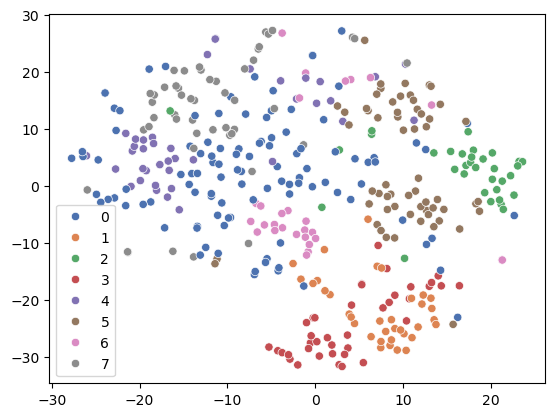

In [92]:

# downsample dim to 2
tsne = TSNE(n_components=2, random_state=RANDOM_STATE, init="random")

# tfidf_content is scipy type matrix
tsne_data = tsne.fit_transform(tfidf_content)

sns.scatterplot(x=tsne_data[:,0], y=tsne_data[:,1], hue=labels, palette="deep") 

## Report
无监督学习更关注数据的内部属性，本次作业实现的流程如下：
- 加载数据，舍弃掉有残缺的数据。舍弃掉authors这个字段，因为作者名不能反映文章的聚焦内容
- 将保留下来的字段拼接成一个大字符串 存到df['combine']中
- 使用nltk工具，将字符串词干化并进行字符串-特征向量的转换（感觉本次作业效果的重点在这里，因为观察到很多论文中出现的通用词 比如什么data ， text， sota，等与领域无关的词，会影响到特征向量的距离计算进而影响分类结果）
- 使用kmeans进行聚类，这里设置成了8类，labels存储在df['lable']中
- 对特征进行降维后（2维）进行可视化，看到在2维上区分出来了几类。（理论上来说降维后保留的维度越高，那么聚类的效果应高越好）